# Assignment: Follow the example from Bootcamp 4, for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:



In [17]:
!pip install classiq
from classiq import *

In [7]:
size = 4  # For a line with 16 nodes


#prepare_minus: Prepares the minus state by applying the X and H gates

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

    
    
#Applies the diffuser oracle based on the input state

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

    
    
#zero_diffuzer: Prepares the initial state and applies the diffuser oracle. 

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle(aux, x))

    
# W Operator Defines the probability distribution for moving between nodes in a circle. 



def W_iteration_line(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * 16
    if i > 0:
        prob[i - 1] = 0.5
    if i < 15:
        prob[i + 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator_line(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        W_iteration_line(i, vertices, adjacent_vertices)

#S Operator: edge_oracle: Determines if the current state satisfies the oracle condition. bitwise_swap: Swaps the bits between two arrays. S_operator: Applies the swap operation based on the oracle result.

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices + adjacent_vertices) % 2) == 1)


@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

#Main Function: main: Initializes the vertices and adjacent vertices, applies the Hadamard transform,
#and then applies the W and S operators. 
#This approach provides a comprehensive setup for both a circle with 4 nodes and a line with 16 nodes,
#demonstrating the flexibility and power of quantum walks for different graph structures

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator_line(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)


State=0, prob vec =[0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

ClassiqAPIError: Call to API failed with code 401: Not authenticated
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

# Coding with qiskit 


In [11]:
!pip install qiskit

In [12]:
# Importing necessary libraries
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [13]:
def initialize_qubits(given_circuit, num_qubits):
    # Initialize the position qubits in superposition
    for qubit in range(num_qubits):
        given_circuit.h(qubit)
    return given_circuit

# Initialize the quantum circuit
num_qubits = 5  # 4 for position and 1 for the coin
qc = QuantumCircuit(num_qubits)
qc = initialize_qubits(qc, num_qubits)

In [14]:
# Coin operation
def coin_operator(given_circuit, coin_qubit):
    given_circuit.h(coin_qubit)
    return given_circuit

# Shift operation
def shift_operator(given_circuit, position_qubits, coin_qubit):
    # Conditional quantum gates for moving left or right
    for i in range(len(position_qubits)):
        given_circuit.ccx(coin_qubit, position_qubits[i], position_qubits[(i+1) % len(position_qubits)])
        given_circuit.x(position_qubits[i])
    return given_circuit

# Add the coin and shift operations to the circuit
qc = coin_operator(qc, num_qubits-1)
qc = shift_operator(qc, list(range(num_qubits-1)), num_qubits-1)

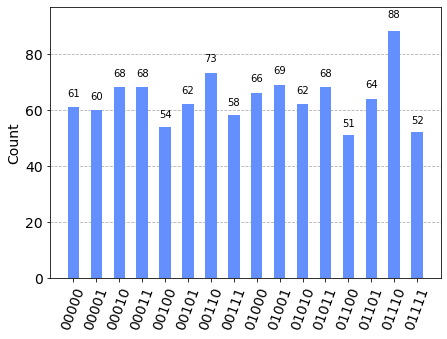

In [15]:
# Adding measurement
qc.measure_all()

# Simulating the quantum circuit
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=simulator, shots=1024).result()
counts = result.get_counts(qc)
plot_histogram(counts)